## Dependencies

In [1]:
from utils import plot_label_freq, Classifier, create_folder, LSTMBackbone, SpectrogramDataset, CLASS_MAPPING, get_device, train, torch_train_val_split, set_seed, test_model, plot_train_val_losses, get_classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np

DATA_PATH = "/home/alex/Downloads/archive(2)/data/"
EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 32
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 256
NUM_LAYERS = 8
NUM_CATEGORIES = 10
PATIENCE=10
DEVICE = get_device()

print(f"Using {DEVICE}")
create_folder("model_weights"), create_folder("assets")

Using cuda


(None, None)

## Step 4

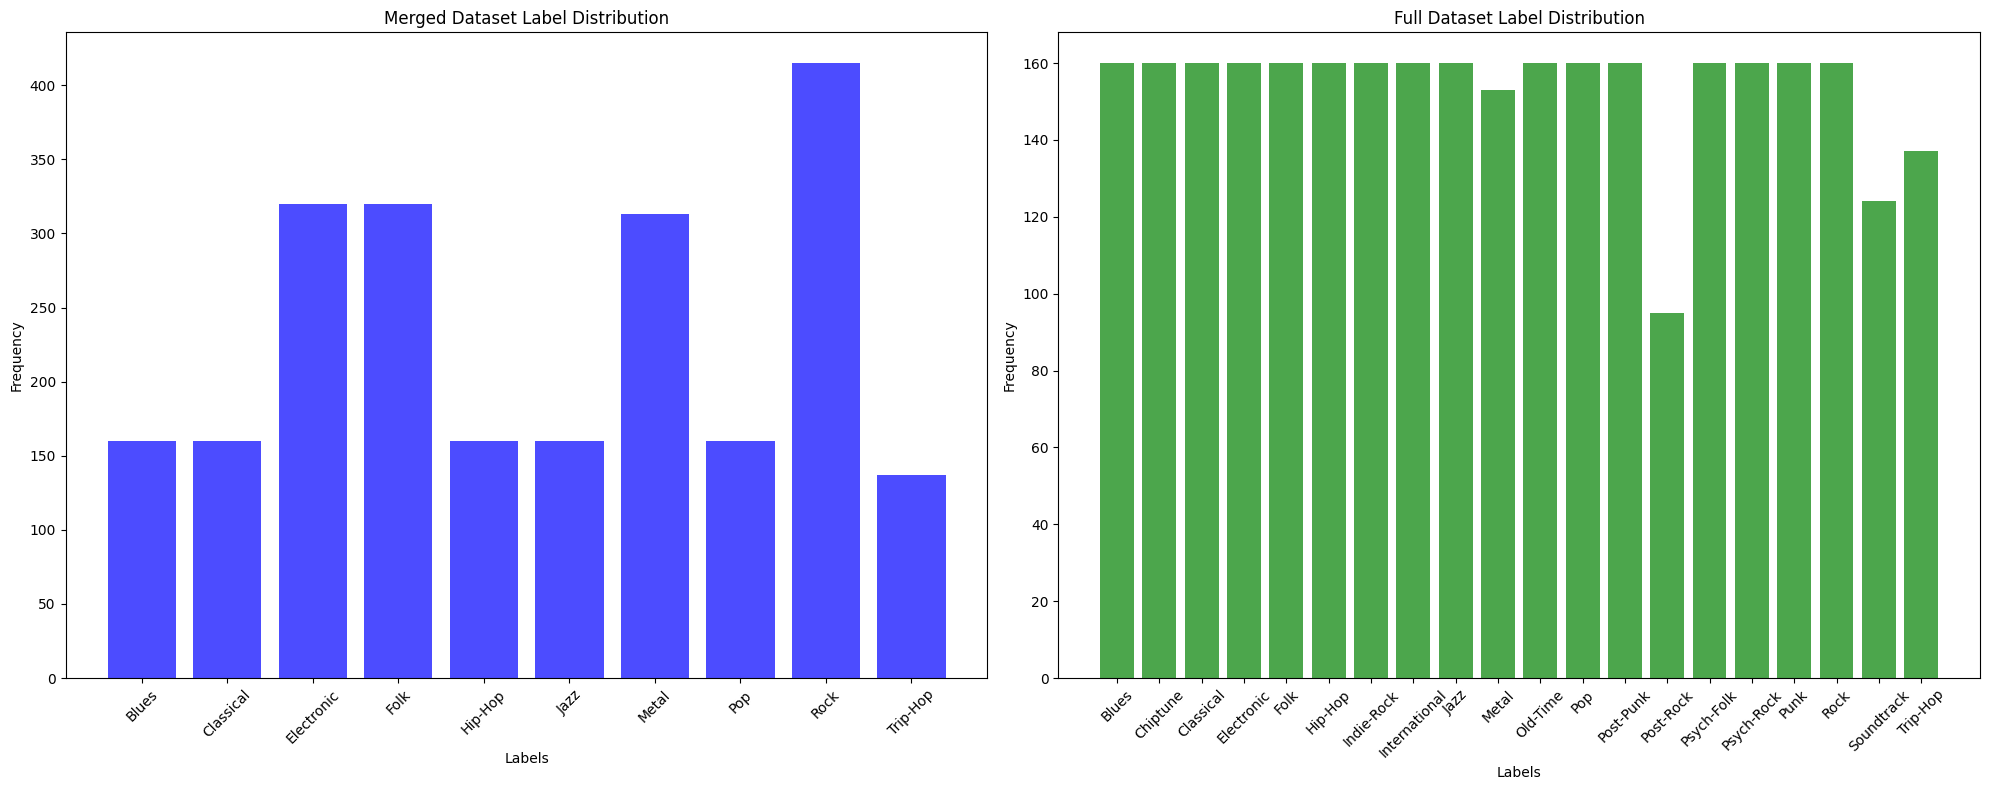

In [ ]:
# get each datasets data
full_dataset = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=None, train=True)
mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)

plot_label_freq(mel_specs_data, full_dataset, save_title="spectogram_genre_labels.png")

del full_dataset, mel_specs_data

## Steps 5 and 6

### Prepare Data

In [2]:
# train / val
mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)
mel_specs_test_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=False)
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(dataset=mel_specs_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
# test
mel_specs_test_dl, _ = torch_train_val_split(dataset=mel_specs_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)


### Overfit LSTM on one batch to make sure everything works

In [ ]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=False)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(model, mel_specs_train_dl, None, optimizer, 400, device=DEVICE, overfit_batch=True)

Training in overfitting mode...
Epoch 1, Loss at training set: 2.322390556335449
Epoch 20, Loss at training set: 2.2425501346588135
Epoch 40, Loss at training set: 2.1816275119781494
Epoch 60, Loss at training set: 2.1283411979675293
Epoch 80, Loss at training set: 2.054823398590088
Epoch 100, Loss at training set: 1.9724799394607544
Epoch 120, Loss at training set: 1.8492927551269531
Epoch 140, Loss at training set: 1.7405803203582764
Epoch 160, Loss at training set: 1.5149903297424316
Epoch 180, Loss at training set: 1.3782154321670532
Epoch 200, Loss at training set: 1.145857572555542
Epoch 220, Loss at training set: 1.0367522239685059
Epoch 240, Loss at training set: 0.9283609986305237
Epoch 260, Loss at training set: 0.7797852754592896
Epoch 280, Loss at training set: 0.8494513034820557
Epoch 300, Loss at training set: 0.6811527013778687
Epoch 320, Loss at training set: 0.7726771235466003
Epoch 340, Loss at training set: 0.6708519458770752
Epoch 360, Loss at training set: 0.650604

### Train LSTM + Classifier on Spectograms

Training started for model model_weights/lstm_genre_mel...
Epoch 1/100
	Average Training Loss: 2.2500405106051216 (94.35s)
	Average Validation Loss: 2.2249516328175862(6.67s)
Epoch 2/100
	Average Training Loss: 2.1729175777270875 (94.59s)
	Average Validation Loss: 2.0734482367833453(6.64s)
Epoch 3/100
	Average Training Loss: 2.0993030461771736 (95.03s)
	Average Validation Loss: 2.111518963177999(6.53s)
Epoch 4/100
	Average Training Loss: 2.0612829039836753 (95.01s)
	Average Validation Loss: 1.9679378430048624(6.56s)
Epoch 5/100
	Average Training Loss: 2.0411265019712777 (95.23s)
	Average Validation Loss: 2.004268010457357(6.68s)
Epoch 6/100
	Average Training Loss: 2.0034745212258964 (95.48s)
	Average Validation Loss: 1.8844130039215088(6.61s)
Epoch 7/100
	Average Training Loss: 1.946854698246923 (95.56s)
	Average Validation Loss: 1.9082002639770508(6.79s)
Epoch 8/100
	Average Training Loss: 1.8987289564362888 (95.54s)
	Average Validation Loss: 1.8221736033757527(6.79s)
Epoch 9/100
	Ave

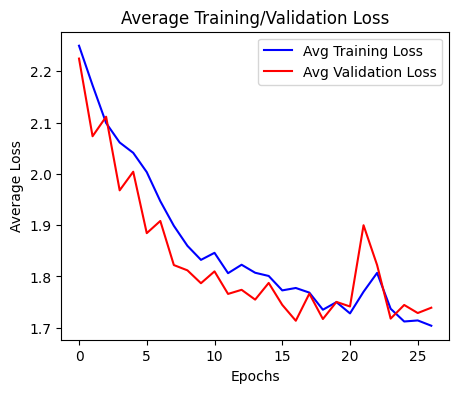

In [ ]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

mel_train_losses, mel_val_losses = train(model, mel_specs_train_dl, mel_specs_val_dl, optimizer,
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_mel.pth', device=DEVICE, overfit_batch=False, patience=PATIENCE)

plot_train_val_losses(mel_train_losses, mel_val_losses, save_title="assets/mel_clf_train_val_losses.png")

In [3]:
print("LSTM evaluation on Mel Spectograms")
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
model = Classifier(NUM_CATEGORIES, backbone)
model.load_state_dict(torch.load("model_weights/lstm_genre_mel.pth", weights_only=True, map_location=DEVICE))
mel_y_true, mel_y_pred = test_model(model, mel_specs_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(mel_y_pred), y_true=np.hstack(mel_y_true))
del mel_specs_train_dl, mel_specs_val_dl, mel_specs_test_data, mel_specs_test_dl

LSTM evaluation on Mel Spectograms
              precision    recall  f1-score   support

           0        nan      0.00      0.00        40
           1       0.50      0.55      0.52        40
           2       0.34      0.56      0.42        80
           3       0.29      0.65      0.40        80
           4       0.00      0.00      0.00        40
           5        nan      0.00      0.00        40
           6       0.45      0.41      0.43        78
           7        nan      0.00      0.00        40
           8       0.31      0.40      0.35       103
           9       0.20      0.06      0.09        34

    accuracy                           0.34       575
   macro avg       0.30      0.26      0.22       575
weighted avg       0.32      0.34      0.28       575

Micro-average precision: 0.34
Micro-average recall: 0.34
Micro-average F1-score: 0.34


### Train LSTM + Classifier on Beat Synced Spectograms

In [9]:
beat_mel_specs_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms_beat/', class_mapping=CLASS_MAPPING,
                                            train=True, feat_type='mel', max_length=-1)
beat_mel_specs_test_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms_beat/", class_mapping=CLASS_MAPPING, train=False)

beat_mel_specs_train_dl, beat_mel_specs_val_dl = torch_train_val_split(dataset=beat_mel_specs_data, batch_eval=32,
                                                                       batch_train=32, val_size=.2, shuffle=True)

beat_mel_specs_test_dl, _ = torch_train_val_split(dataset=beat_mel_specs_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)

Training started for model model_weights/lstm_genre_beat_mel...
Epoch 1/100
	Average Training Loss: 2.2487485079929748 (6.75s)
	Average Validation Loss: 2.2003947416941325(0.71s)
Epoch 2/100
	Average Training Loss: 2.125733661240545 (6.78s)
	Average Validation Loss: 2.0424983501434326(0.45s)
Epoch 3/100
	Average Training Loss: 2.050206618062381 (6.91s)
	Average Validation Loss: 2.0159781138102213(0.47s)
Epoch 4/100
	Average Training Loss: 2.0248252215056586 (6.74s)
	Average Validation Loss: 1.9668604612350464(0.54s)
Epoch 5/100
	Average Training Loss: 1.9620017984817768 (7.11s)
	Average Validation Loss: 1.9204678058624267(0.48s)
Epoch 6/100
	Average Training Loss: 1.940386541958513 (6.98s)
	Average Validation Loss: 1.8654561122258504(0.71s)
Epoch 7/100
	Average Training Loss: 1.9326234295450408 (6.94s)
	Average Validation Loss: 1.8744428237279256(0.47s)
Epoch 8/100
	Average Training Loss: 1.877289291085868 (7.29s)
	Average Validation Loss: 1.860277525583903(0.51s)
Epoch 9/100
	Average 

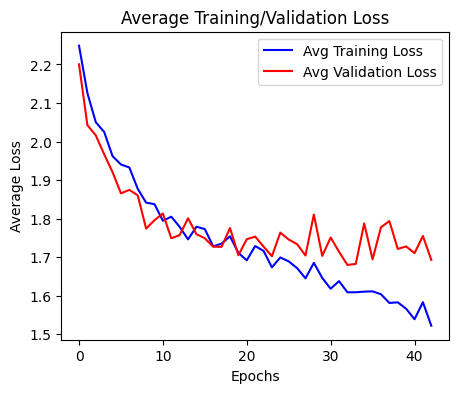

In [ ]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

beat_mel_train_losses, beat_mel_val_losses = train(model, beat_mel_specs_train_dl, beat_mel_specs_val_dl, optimizer,
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_beat_mel.pth', device=DEVICE, overfit_batch=False, patience=PATIENCE)

plot_train_val_losses(beat_mel_train_losses, beat_mel_val_losses, save_title="assets/beat_mel_clf_train_val_losses.png")

In [10]:
print("LSTM evaluation on Beat-Synced Mel Spectograms")
backbone = LSTMBackbone(beat_mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
model = Classifier(NUM_CATEGORIES, backbone)
model.load_state_dict(torch.load("model_weights/lstm_genre_beat_mel.pth", weights_only=True, map_location=DEVICE))
beat_mel_y_true, beat_mel_y_pred = test_model(model, beat_mel_specs_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(beat_mel_y_pred), y_true=np.hstack(beat_mel_y_true))
del beat_mel_specs_train_dl, beat_mel_specs_val_dl, beat_mel_specs_test_dl, beat_mel_specs_data, beat_mel_specs_test_data

LSTM evaluation on Beat-Synced Mel Spectograms
              precision    recall  f1-score   support

           0        nan      0.00      0.00        40
           1       0.45      0.62      0.52        40
           2       0.44      0.71      0.54        80
           3       0.36      0.61      0.46        80
           4       0.20      0.30      0.24        40
           5       0.21      0.10      0.14        40
           6       0.53      0.62      0.57        78
           7        nan      0.00      0.00        40
           8       0.41      0.29      0.34       103
           9       0.20      0.06      0.09        34

    accuracy                           0.39       575
   macro avg       0.35      0.33      0.29       575
weighted avg       0.38      0.39      0.34       575

Micro-average precision: 0.39
Micro-average recall: 0.39
Micro-average F1-score: 0.39


### Train LSTM + Classifier on Chromagrams

In [11]:
chroma_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING,
                                        train=True, feat_type='chroma', max_length=-1)
chroma_test_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING,
                                    train=False, feat_type='chroma', max_length=-1)

chroma_train_dl, chroma_val_dl = torch_train_val_split(dataset=chroma_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
chroma_test_dl, _ = torch_train_val_split(dataset=chroma_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)

Training started for model model_weights/lstm_genre_chroma...
Epoch 1/100
	Average Training Loss: 2.2528662558259636 (91.73s)
	Average Validation Loss: 2.2246153513590494(6.29s)
Epoch 2/100
	Average Training Loss: 2.226938609419198 (91.34s)
	Average Validation Loss: 2.225297705332438(6.16s)
Epoch 3/100
	Average Training Loss: 2.226618063860926 (91.31s)
	Average Validation Loss: 2.216348568598429(6.32s)
Epoch 4/100
	Average Training Loss: 2.2223409866464547 (91.40s)
	Average Validation Loss: 2.212813472747803(6.40s)
Epoch 5/100
	Average Training Loss: 2.206836729214109 (92.34s)
	Average Validation Loss: 2.1806278228759766(6.69s)
Epoch 6/100
	Average Training Loss: 2.183588673328531 (92.57s)
	Average Validation Loss: 2.1576563040415446(6.22s)
Epoch 7/100
	Average Training Loss: 2.174932671004328 (92.75s)
	Average Validation Loss: 2.1545098463694257(6.22s)
Epoch 8/100
	Average Training Loss: 2.1782805097514184 (92.90s)
	Average Validation Loss: 2.174025217692057(6.22s)
Epoch 9/100
	Averag

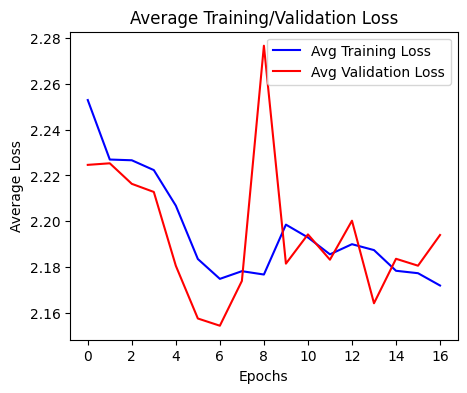

In [8]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(chroma_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

chroma_train_losses, chroma_val_losses = train(model, chroma_train_dl, chroma_val_dl, optimizer,
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_chroma.pth', device=DEVICE, overfit_batch=False, patience=PATIENCE)

plot_train_val_losses(chroma_train_losses, chroma_val_losses, save_title="assets/chroma_clf_train_val_losses.png")

In [12]:
print("LSTM evaluation on Chromagrams")
backbone = LSTMBackbone(chroma_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
model = Classifier(NUM_CATEGORIES, backbone)
model.load_state_dict(torch.load("model_weights/lstm_genre_chroma.pth", weights_only=True, map_location=DEVICE))
chroma_y_true, chroma_y_pred = test_model(model, chroma_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(chroma_y_pred), y_true=np.hstack(chroma_y_true))
del chroma_train_dl, chroma_val_dl, chroma_test_dl, chroma_data, chroma_test_data

LSTM evaluation on Chromagrams
              precision    recall  f1-score   support

           0        nan      0.00      0.00        40
           1        nan      0.00      0.00        40
           2       0.14      0.07      0.10        80
           3       0.25      0.57      0.35        80
           4        nan      0.00      0.00        40
           5        nan      0.00      0.00        40
           6       0.26      0.37      0.31        78
           7        nan      0.00      0.00        40
           8       0.21      0.50      0.30       103
           9        nan      0.00      0.00        34

    accuracy                           0.23       575
   macro avg       0.22      0.15      0.11       575
weighted avg       0.22      0.23      0.16       575

Micro-average precision: 0.23
Micro-average recall: 0.23
Micro-average F1-score: 0.23


### Train LSTM + Classifier on Spectograms + Chromagrams (Fused)

In [13]:
fused_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING,
                                    train=True, feat_type='fused', max_length=-1)
fused_test_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING,
                                    train=True, feat_type='fused', max_length=-1)

fused_train_dl, fused_val_dl = torch_train_val_split(dataset=fused_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
fused_test_dl, _ = torch_train_val_split(dataset=fused_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)

Training started for model model_weights/lstm_genre_fused...
Epoch 1/100
	Average Training Loss: 2.249410004451357 (93.84s)
	Average Validation Loss: 2.2145383834838865(6.75s)
Epoch 2/100
	Average Training Loss: 2.160735278294004 (94.32s)
	Average Validation Loss: 2.0372857173283894(6.81s)
Epoch 3/100
	Average Training Loss: 2.080537062266777 (94.80s)
	Average Validation Loss: 2.00355920791626(6.81s)
Epoch 4/100
	Average Training Loss: 2.049264605703025 (94.94s)
	Average Validation Loss: 1.949915838241577(6.85s)
Epoch 5/100
	Average Training Loss: 2.0219030277482393 (95.29s)
	Average Validation Loss: 1.9898454427719117(6.68s)
Epoch 6/100
	Average Training Loss: 1.9957494221884629 (95.34s)
	Average Validation Loss: 1.909914525349935(6.61s)
Epoch 7/100
	Average Training Loss: 1.9638043621490742 (95.28s)
	Average Validation Loss: 1.928574514389038(6.61s)
Epoch 8/100
	Average Training Loss: 1.9552303675947518 (95.45s)
	Average Validation Loss: 1.983643396695455(6.61s)
Epoch 9/100
	Average 

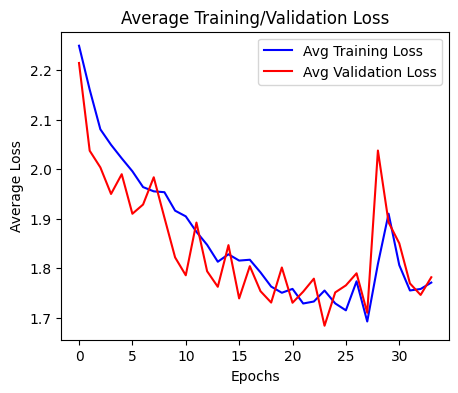

In [4]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(fused_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

fused_train_losses, fused_val_losses = train(model, fused_train_dl, fused_val_dl, optimizer,
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_fused.pth', device=DEVICE, overfit_batch=False, patience=PATIENCE)

plot_train_val_losses(fused_train_losses, fused_val_losses, save_title="assets/fused_clf_train_val_losses.png")

In [14]:
print("LSTM evaluation on Fused Spectograms + Chromagrams")
backbone = LSTMBackbone(fused_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
model = Classifier(NUM_CATEGORIES, backbone)
model.load_state_dict(torch.load("model_weights/lstm_genre_fused.pth", weights_only=True, map_location=DEVICE))
fused_y_true, fused_y_pred = test_model(model, fused_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(fused_y_pred), y_true=np.hstack(fused_y_true))
del fused_train_dl, fused_val_dl, fused_test_dl, fused_data, fused_test_data

LSTM evaluation on Fused Spectograms + Chromagrams
              precision    recall  f1-score   support

           0        nan      0.00      0.00       160
           1       0.70      0.74      0.72       160
           2       0.35      0.78      0.48       320
           3       0.37      0.57      0.45       320
           4       0.23      0.09      0.13       160
           5       0.11      0.01      0.01       160
           6       0.46      0.58      0.51       313
           7        nan      0.00      0.00       160
           8       0.33      0.31      0.32       415
           9       0.32      0.09      0.14       137

    accuracy                           0.39      2305
   macro avg       0.36      0.32      0.28      2305
weighted avg       0.36      0.39      0.32      2305

Micro-average precision: 0.39
Micro-average recall: 0.39
Micro-average F1-score: 0.39
